#Problem Statement

The goal is to extract a named entity from movie trivia. For example, the tags are for movie name, actor name, director name, and movie plot. General libraries might extract the names but don't differentiate between actor and director, and it would be challenging to extract movie plots. We need to build the customer model that predicts these tags for the sentences on movies.

Essentially, we have a data set that talks about the movies. It consists of sentences or questions on movies, and each of those words in the sentence has a predefined tag. We need to build the NER model to predict these tags.

Along the way, we need to understand these concepts.

1. Build the model using various algorithms.

2. Design a metric to measure the performance of the model.

3. Understand where the model fails and what might be the reason for the failure.

4. Fine-tune the model.

5. Repeat these steps until we achieve the best accuracy on the test data.




#Methodology and Approach

NER identifies the entities in a text and classifies them into predefined categories such as location, a person's name, organization name, and more. But for this problem, we need to tag the director's name, actor's name, genre, and movie character (likewise, there are 25 such tags defined in the data set) for the entities in a sentence. So NER alone does not suffice. Here let's build custom models and train them using conditional random fields and BERT.

The steps to solve this problem are as follows.

1. Data collection

2. Data understanding

3. Data preprocessing

4. Feature mapping

5. Model Building
* Conditional random fields
*   BERT

6. Hyperparameter tuning

7. Evaluating the model

8. Prediction on random sentences

 Figure 2 shows how the product works at a high level.

 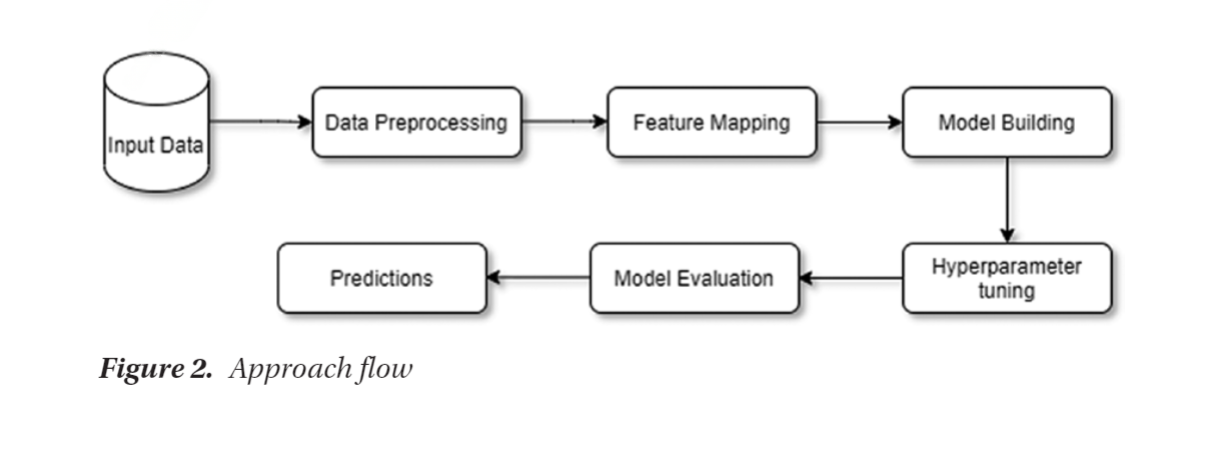

# Implementation

We understood the problem statement as well as various approached to solve it. Let's start the implementation of the project. We begin with importing and understanding the data.

# Data

We used data from the MIT movie corpus, which is in .bio format. Download the trivia10k13train.bio and trivia10k13test.bio data sets from https://groups.csail.mit.edu/sls/downloads/movie/.

Now let's convert the data into a pandas data frame using the following code.

In [1]:
# create a function to add a column sentence that indicates the sentence u=id for each txt file as a preprocessing step.

import pandas as pd

def data_conversion(file_name):

  df_eng=pd.read_csv(file_name, delimiter='\t', header=None, skip_blank_lines=False)

  df_eng.columns=['tag', 'tokens']

  tempTokens=list(df_eng['tokens'])

  tempSentence = list()

  count = 1

  for i in tempTokens:

    tempSentence.append("Sentence" + str(count))

    tempTokens = list(df_eng['tokens'])

    if str(i) == 'nan':

      count = count+1

  dfSentence =  pd.DataFrame (tempSentence, columns=['Sentence'])

  result = pd.concat([df_eng, dfSentence], axis=1, join='inner')

  return result

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# passing the text files to function

trivia_train=data_conversion('/content/drive/MyDrive/trivia10k13train.bio.txt')

trivia_test=data_conversion('/content/drive/MyDrive/trivia10k13test.bio.txt')

#Train Data Preparation

Let's look at the first five rows of the training data.

In [4]:
trivia_train.head()

,tag,tokens,Sentence
0,B-Actor,steve,Sentence1
1,I-Actor,mcqueen,Sentence1
2,O,provided,Sentence1
3,O,a,Sentence1
4,B-Plot,thrilling,Sentence1


Next, we check the number of rows and columns present in the training data set.

In [5]:
trivia_train.shape

(166639, 3)


There are a total of 166,639 rows and three columns. Let's check how many unique words are present in the training data set

In [6]:
trivia_train.tokens.nunique()

10986

There are 10,986 unique words for the training data. Now, let's check if there are any null values present in the training data set.

In [7]:
trivia_train.isnull().sum()

tag         7816
tokens      7817
Sentence       0
dtype: int64

There are 7817 null rows.Let's drop the null rows using the following code.

In [8]:
trivia_train.dropna(inplace=True)

#Test Data Preparation

Let's look at the first five rows of the test data.

In [9]:
trivia_test.head()

,tag,tokens,Sentence
0,O,i,Sentence1
1,O,need,Sentence1
2,O,that,Sentence1
3,O,movie,Sentence1
4,O,which,Sentence1



Next, we check the number of rows and columns present in the test data set.


In [10]:
trivia_test.shape

(40988, 3)


There are a total of 40,988 rows and three columns. Let's check how many unique words are present in the test data set.

In [11]:
trivia_test.tokens.nunique()

5786

There are 5786 unique words for test data. Now, let's check if there are any null values present in the test data set.

In [12]:
trivia_test.isnull().sum()

tag         1953
tokens      1953
Sentence       0
dtype: int64

There are 1953 null rows.Let's drop the null rows using the following code.

In [13]:
trivia_test.dropna(inplace=True)


The data set consists of three columns after extraction.



*   **tag** is the category of words
*   **tokens** consist of words
*   **sentence** is the sentence number in which a word belongs



There are a total of 24 (excluding the O tag) unique tags in the given training data set.

Their distribution is as follows.

<Axes: >

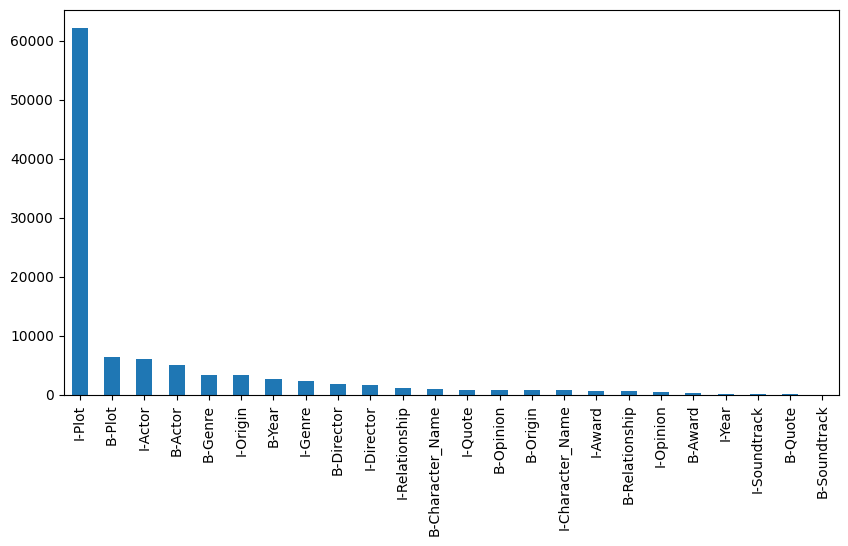

In [14]:
# get the distribution plot for the tags.

trivia_train[trivia_train ["tag"]!="O"]["tag"].value_counts(). plot (kind="bar", figsize=(10,5))

Now, let's create a copy of train and test data for the further analysis and model build.

In [15]:
data=trivia_train.copy()

data1=trivia_test.copy()

Now, let's rename the columns using the following code

In [16]:
data.rename(columns={"Sentence": "sentence_id", "tokens": "words","tag": "labels"}, inplace =True)

data1.rename(columns={"Sentence": "sentence_id", "tokens": "words","tag": "labels"}, inplace =True)

#Model Building

##Conditional Random Fields (CRF)

CRF is a conditional model class best suited to prediction tasks where the state of neighbors or contextual information affects the current prediction.

The main applications of CRFS are named-entity recognition, part of speech tagging,gene prediction, noise reduction, and object detection problems, to name a few.

In a sequence classification problem, the final goal is to find the probability of y(target) given input of sequence vector x.

Because conditional random fields are conditional models, they apply logistic regression to sequence data.

Conditional distribution is basically

                                                Y = argmax P(y|x)

This finds the best output (probability) given sequence.x.

In CRF, the input data is expected to be sequential, so we have to label the data as position i for the data point we are predicting.

We define feature functions for each variable; in this case, there is no POS tag. We only use one feature function.

The feature function's main purpose is to express a characteristic of the sequence that the data point represents.

Each feature function is relatively based on the label of the previous word and the current word. It is either a 0 or a 1.

So, to build CRI as we do in other models, assign some weights to each feature
function and let weights update by optimization algorithm like gradient descent.

Maximum likelihood estimation is used to estimate parameters, where we take the negative log of distribution to make the derivative easier to calculate.

In general,

1. Define feature function.

2. Initialize weights to random values.

3. Apply gradient descent to parameter values to converge.

CRF's are more likely similar to logistic regression since they use *conditional probability distribution*. But, we extend the algorithm by applying feature functions as the sequential input.

We aim to extract entities from the given sentence and identifying their types using the CRF Model. Now let's import the required libraries.

We used the following libraries.

In [17]:
# For visualization
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(color_codes=True)

sns.set(font_scale=1)

%matplotlib inline

%config InlineBackend. figure_format = 'svg'

# For Modeling

!pip install sklearn_crfsuite

!pip install eli5

from sklearn.ensemble import RandomForestClassifier

from sklearn_crfsuite import CRF, scorers, metrics

from sklearn_crfsuite.metrics import flat_classification_report

from sklearn.metrics import classification_report, make_scorer

import scipy.stats

import eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 14.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=c67af88f832ce502cd779eb6a5fbeb45ad329a15f6eddebe617178f9f42009a4
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


Let's create grouped words and their corresponding tags as a tuple. Also, let's store the words of the same sentence in one list using the following sentence generator function.

In [18]:
class Get_Sent(object):

  def __init__(self, dataset):

    self.n_sent = 1

    self.dataset = dataset

    self.empty = False

    agg_func = lambda s: [(a, b) for a,b in zip (s["words"].values.tolist(),s["labels"].values.tolist())]

    self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)

    self.sentences = [x for x in self.grouped]

def get_next(self):

  try:

    s = self.grouped ["Sentence: {}".format(self.n_sent)]

    self.n_sent += 1

  except:

    return None

# calling the Get_Sent function and passing the train dataset

Sent_get= Get_Sent(data)

sentences=Sent_get.sentences

In [19]:
# calling the Get_Sent function and passing the test dataset

Sent_get= Get_Sent(data1)

sentences1 = Sent_get.sentences

# This is what a sentence will look like.

print (sentences1[0])

# shows the output of the Gent_set function for test data.

[('i', 'O'), ('need', 'O'), ('that', 'O'), ('movie', 'O'), ('which', 'O'), ('involves', 'O'), ('aliens', 'B-Plot'), ('invading', 'I-Plot'), ('earth', 'I-Plot'), ('in', 'I-Plot'), ('a', 'I-Plot'), ('particular', 'I-Plot'), ('united', 'I-Plot'), ('states', 'I-Plot'), ('place', 'I-Plot'), ('in', 'I-Plot'), ('california', 'I-Plot')]


For converting text into numeric arrays, we use simple and complex features.

# Simple Feature Mapping

In this mapping, we have considered simple mapping of words and considered only six features of each word.


*   word title

*   word  title lower string

*   word  title upper string

*   length of word

*   word numeric

*   word alphabet




Let's look at the code for simple feature mapping.

In [20]:
# feature mapping for the classifier.
import numpy as np

def create_ft(txt):

  return np.array([txt.istitle(), txt.islower(), txt.isupper(), len(txt), txt.isdigit(), txt.isalpha()])

# using the above function created to get the mapping of words for train data.

words  = [create_ft(x) for x in data ["words"].values.tolist()]

# lets take unique labels

target = data["labels"].values.tolist()

# print few words with array

print (words[:5])

# we get mapping of words as below (for first five words)

[array([0, 1, 0, 5, 0, 1]), array([0, 1, 0, 7, 0, 1]), array([0, 1, 0, 8, 0, 1]), array([0, 1, 0, 1, 0, 1]), array([0, 1, 0, 9, 0, 1])]


Likewise, we use the function created for the test data.

In [22]:
# using the above function created to get the mapping of words for test data.

words1 = [create_ft(x) for x in data1["words"].values.tolist()]

target1 = data1["labels"].values.tolist()

# Apply five-fold cross validation for the random classifier model and get the results as follows. Next, the cross_val_predict function is used. It is defined in sklearn.

# importing package

from sklearn.model_selection import cross_val_predict

# train the RF model

Ner_prediction = cross_val_predict(RandomForestClassifier(n_estimators=20), X=words, y=target, cv=10)

# import library

from sklearn.metrics import classification_report

Accuracy_rpt = classification_report(y_pred=Ner_prediction, y_true=target, zero_division=1)

print(Accuracy_rpt)

                  precision    recall  f1-score   support

         B-Actor       1.00      0.00      0.00      5010
         B-Award       1.00      0.00      0.00       309
B-Character_Name       1.00      0.00      0.00      1024
      B-Director       1.00      0.00      0.00      1787
         B-Genre       1.00      0.00      0.00      3384
       B-Opinion       1.00      0.00      0.00       810
        B-Origin       1.00      0.00      0.00       779
          B-Plot       1.00      0.00      0.00      6468
         B-Quote       1.00      0.00      0.00       126
  B-Relationship       1.00      0.00      0.00       580
    B-Soundtrack       1.00      0.00      0.00        50
          B-Year       0.88      0.99      0.93      2702
         I-Actor       0.51      0.01      0.01      6121
         I-Award       1.00      0.00      0.00       719
I-Character_Name       1.00      0.00      0.00       760
      I-Director       1.00      0.00      0.00      1653
         I-Ge

Accuracy is 45%, and the overall F1 score is 0.39. The performance is not so good. Now let's further improve the accuracy, leveraging more features, like "pre" and "post" words.